In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
ds=tf.data.Dataset.list_files('/content/drive/MyDrive/images/*.png',shuffle=False)
ds = ds.map(load_image)
ds = ds.map(lambda x: tf.image.resize(x, (32,32)))
ds = ds.map(lambda x: (x-127.5)/127.5)

In [14]:
len(ds)

126

In [17]:
#lets do some duplication and concatinate to make varietyo of images
ds_copy=ds
ds = ds.concatenate(ds_copy)


In [18]:
len(ds)

1008

(32, 32, 3)


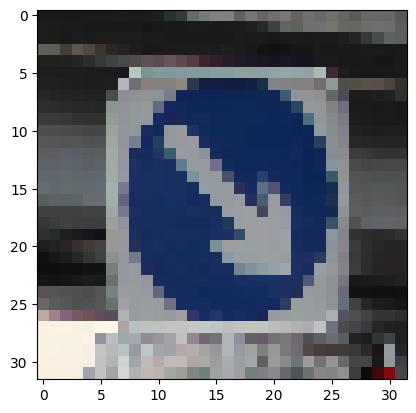

In [19]:
for elements in ds.take(1):
    plt.imshow((elements+1)/2)
    print(elements.shape)

In [20]:
batch_size=16
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(batch_size)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(8)

### building the model

In [21]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,Input,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D,Activation,Conv2DTranspose

In [22]:
def build_generator():
    model=Sequential()
    model.add(Input(shape=(100,)))
    model.add(Dense(128 * 16 * 16, activation='relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Reshape((16, 16, 128)))


    model.add(Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))


    model.add(Conv2DTranspose(128, 4, strides=2,padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))



    model.add(Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2D(3, kernel_size=5, strides=1,padding='same'))
    model.add(Activation("tanh"))

    return model








In [23]:
generator=build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 3)           │           9,603 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,943,747 (18.86 MB)

 Trainable params: 4,877,187 (18.60 MB)

 Non-trainable params: 66,560 (260.00 KB)

In [24]:
img = generator.predict(np.random.randn(4,100,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


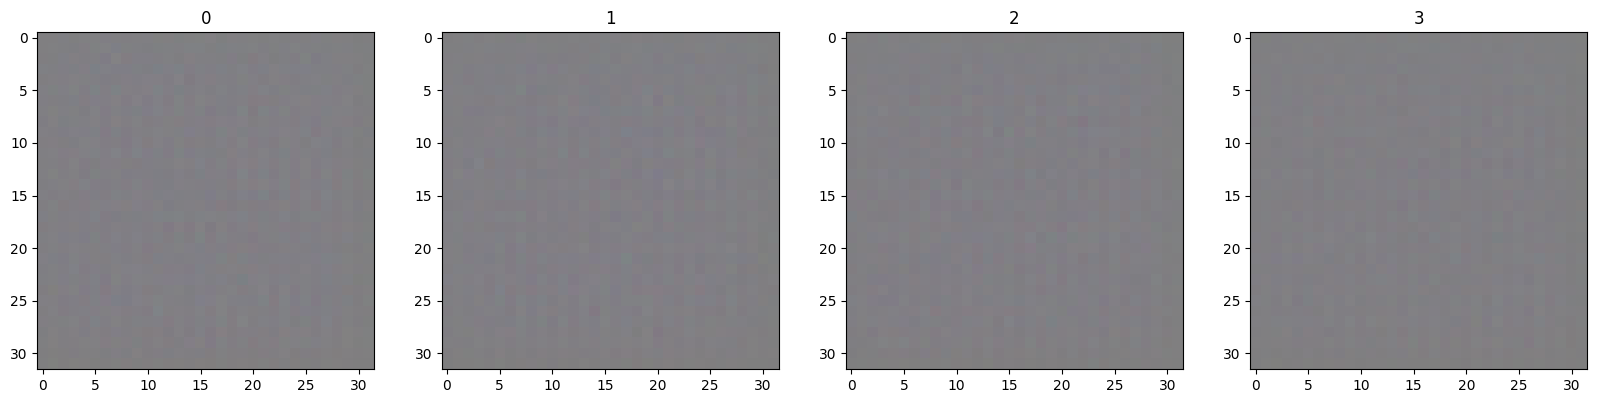

In [25]:
# Generate new fashion
img = generator.predict(np.random.randn(4,100,1))

def rescale(img):
    img=img+1/2
    return img

img=rescale(img)
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

# Building a discriminator model

In [26]:
def build_discriminator():

    model=Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))



    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))



    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))


    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.1))




    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))


    return model


In [27]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 794,497 (3.03 MB)

 Trainable params: 793,473 (3.03 MB)

 Non-trainable params: 1,024 (4.00 KB)

## loss and optimizers

In [28]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [29]:
g_opt = Adam(0.0002,0.5)
d_opt = Adam(0.0002,0.5)


### losses

In [30]:
def discriminator_loss(real_output, fake_output):
    bce = BinaryCrossentropy(from_logits=True)



    # Apply noise to labels
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    # Compute losses
    real_loss = bce(real_labels, real_output)
    fake_loss = bce(fake_labels, fake_output)

    # Total loss
    total_loss = real_loss + fake_loss
    return total_loss

In [31]:
def generator_loss(fake_output):
    bce = BinaryCrossentropy(from_logits=True)
    t_loss = bce(tf.ones_like(fake_output), fake_output)
    return t_loss

In [32]:
g_loss=generator_loss
d_loss=discriminator_loss

### model subclassing

In [33]:
from tensorflow.keras.models import Model
noise_dim=100


In [34]:
class trafficgan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,images):
        noise=tf.random.normal([batch_size,noise_dim])
        with tf.GradientTape() as d_tape:
            gen_images=self.generator(noise,training=False)
            fake_output=self.discriminator(gen_images,training=True)
            real_output=self.discriminator(images,training=True)
            disc_loss=self.d_loss(real_output,fake_output)

        dgrad = d_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        for _ in range(2):
            with tf.GradientTape() as g_tape:
                gen_images=self.generator(noise,training=True)
                fake_output=self.discriminator(gen_images,training=False)
                gen_loss=self.g_loss(fake_output)

            ggrad = g_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"discriminator_loss":disc_loss, "generator_loss":gen_loss}









In [35]:
traffic=trafficgan(generator,discriminator)

In [36]:
traffic.compile(g_opt,d_opt,g_loss,d_loss)

In [37]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [38]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy().astype(np.uint8)
        for i in range(self.num_img):
            img = generated_images[i]

            # Save image using cv2.imwrite
            save_path = f'/content/drive/My Drive/modelimagesone/generated_img_{epoch}_{i}.png'
            cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [47]:
#hist = traffic.fit(ds, epochs=100,callbacks=[ModelMonitor()])

In [40]:
imgs = generator.predict(tf.random.normal((16, 100, 1)))
imgs.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


(16, 32, 32, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


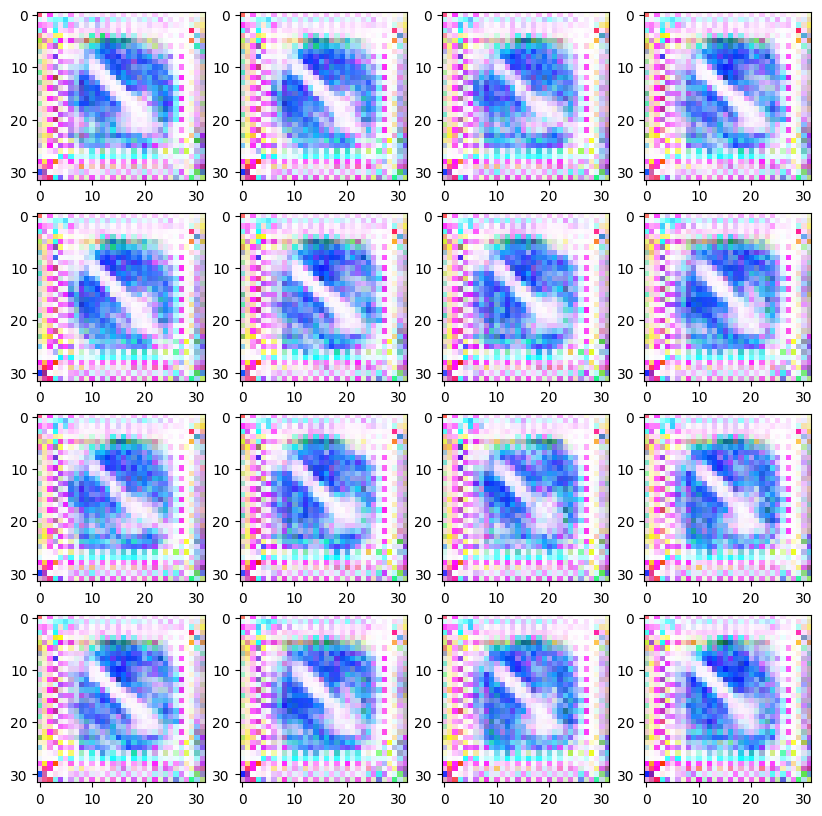

In [42]:
imgs = generator.predict(tf.random.normal((16, 100, 1)))

def rescale_images(images):
    return (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]


img_rescaled = rescale_images(imgs)

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(img_rescaled[(r+1)*(c+1)-1])
plt.savefig('/content/drive/My Drive/generated_grid.png')

In [43]:
save_path = '/content/drive/My Drive/generatorofkeepright.h5'

# Save the model
generator.save(save_path)

In [ ]:
# Save the entire model to a HDF5 file
discriminator.save('discriminatormodelone.h5')

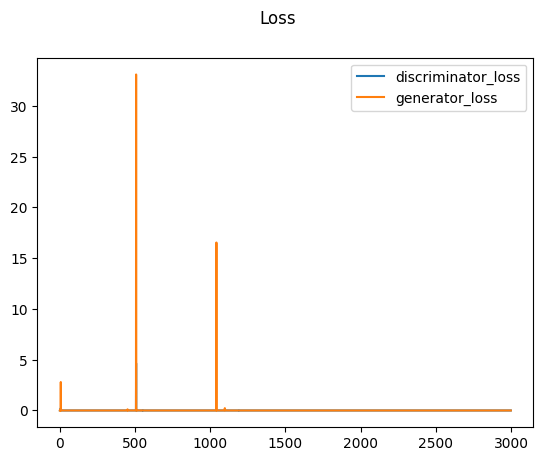

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['discriminator_loss'], label='discriminator_loss')
plt.plot(hist.history['generator_loss'], label='generator_loss')
plt.legend()
plt.show()